In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

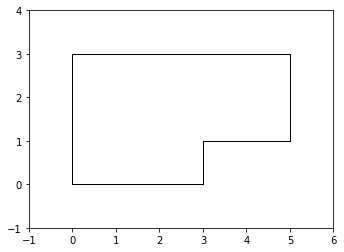

In [2]:
corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4]);

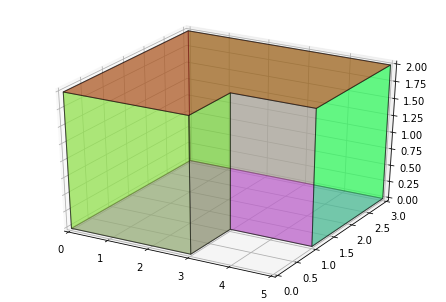

In [3]:
room = pra.Room.from_corners(corners)
room.extrude(2.)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

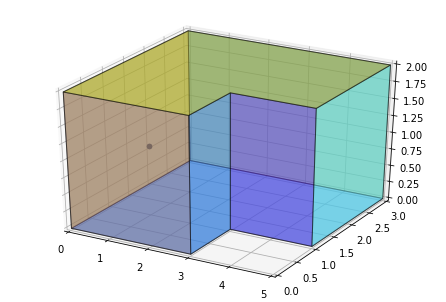

In [12]:
# specify signal source
fs, signal = wavfile.read("vad_train_set/audio/f1_00152f00-2a54-43d4-817e-d1eeb8259087.wav")

# add source to 2D room
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, air_absorption=True)
room.extrude(2., materials=pra.Material(0.2, 0.15))
room.add_source([1.,1.,1.], signal=signal)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

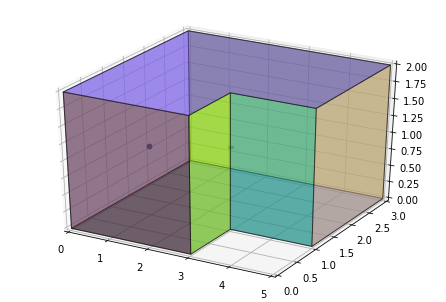

In [17]:
#R = pra.linear_2D_array(center=[2.5,1.5], M=2, phi=0 ,d=0.071)
#room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
R = np.array([[2.5, 2.571], [1.5, 1.5], [1.,  1.]])  # [[x], [y], [z]]
room.add_microphone(R)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

In [24]:
room.mic_array.signals = signal.T

In [25]:
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

## Beamforming

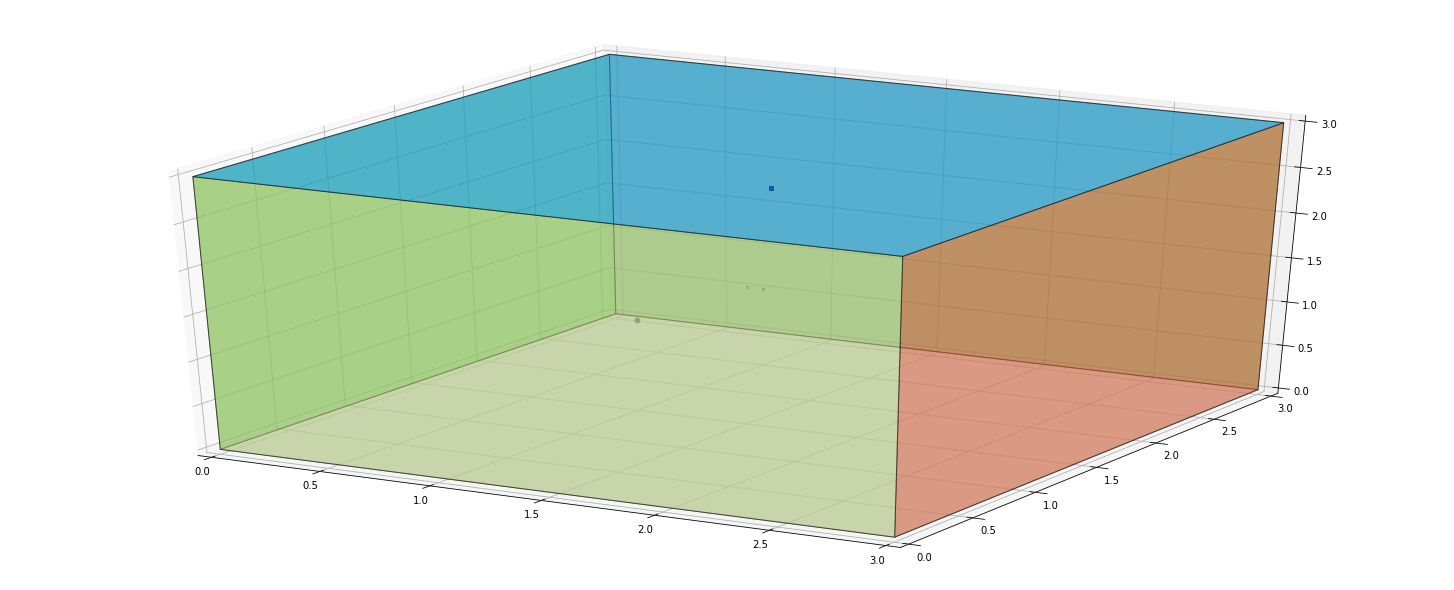

In [194]:
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples
sigma2_n = 5e-7


# specify signal and noise source
fs, signal = wavfile.read("vad_train_set/audio/f1_01165f84-9678-4518-bf69-a8a9cb8b958a.wav")
#fs, noise = wavfile.read("vad_train_set/audio/f1_00152f00-2a54-43d4-817e-d1eeb8259087.wav") 

rt60_tgt = 0.3  # seconds
room_dim = [3, 3, 3]  # meters
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)
room_bf = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order)

room_center = [dim / 2 for dim in room_dim]


r = 1
source_azimuth = 2.74691584684417
source_elevation = -0.7765585910432178
noise_azimuth = 1.6735298230974647
noise_elevation = 1.3413477220678458

speech_source = [r*np.cos(source_azimuth)*np.cos(source_elevation) + room_center[0],
                r*np.sin(source_azimuth)*np.cos(source_elevation) + room_center[1],
                r*np.sin(source_elevation) + room_center[2]] # x,y,z

noise_source = [r*np.cos(noise_azimuth)*np.cos(noise_elevation) + room_center[0],
                r*np.sin(noise_azimuth)*np.cos(noise_elevation) + room_center[1],
                r*np.sin(noise_elevation) + room_center[2]] # x,y,z

# Create 4x6 shoebox room with source and interferer and simulate
#room_bf = pra.ShoeBox([4,6], fs=fs, max_order=12)
#room_bf = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, air_absorption=True)
#room_bf.extrude(2., materials=pra.Material(0.2, 0.15))
#source = np.array([1, 1.,1.])
#interferer = np.array([2.,2., 2.])
room_bf.add_source(speech_source, delay=0., signal=signal.T[0,:])
room_bf.add_source(noise_source, delay=0, signal=np.zeros_like(signal.T[0,:]))
#room_bf.add_source(interferer, delay=0., signal=noise.T[0,:len(signal)])

# Create geometry equivalent to Amazon Echo
#center = [2, 1.5]; radius = 37.5e-3
fft_len = 512
#echo = pra.circular_2D_array(center=center, M=2, phi0=0, radius=radius)
#echo = np.concatenate((echo, np.array(center, ndmin=2).T), axis=1)
R = np.array([[room_center[0], room_center[0] + 0.071], 
              [room_center[1], room_center[1]], 
              [room_center[2], room_center[2]]])  # [[x], [y], [z]]
#room_bf.add_microphone(R)
mics = pra.Beamformer(R, room_bf.fs, N=fft_len, Lg=Lg)
room_bf.add_microphone_array(mics)

# Compute DAS weights
#mics.rake_delay_and_sum_weights(room_bf.sources[0][:1])
mics.rake_mvdr_filters(room_bf.sources[0][:1] , room_bf.sources[1][:1] , sigma2_n * np.eye(mics.Lg * mics.M))
#mics.rake_perceptual_filters(room_bf.sources[0][0:1] , room_bf.sources[1][0:1] , sigma2_n * np.eye(mics.Lg * mics.M))

# plot the room and resulting beamformer before simulation
fig, ax = room_bf.plot(freq=[500, 1000, 2000, 4000], img_order=0)
fig.set_size_inches(20, 8)
#ax.legend(['500', '1000', '2000', '4000'])


In [195]:
room_bf.compute_rir()
room_bf.simulate()
#room.simulate(reference_mic=0, snr=10)
print("Center Mic:")
IPython.display.Audio(room_bf.mic_array.signals[-1,:], rate=fs)

Center Mic:


In [196]:
#room_bf.mic_array.signals[:,:signal.shape[0]] = signal.T
room_bf.mic_array.record(signal.T, fs)

In [201]:
signal_das = mics.process(FD=False)
print("DAS Beamformed Signal:")
IPython.display.Audio(signal_das, rate=fs)
#out_RakeMVDR = pra.normalize(pra.highpass(signal_das, fs))
#IPython.display.Audio(out_RakeMVDR, rate=fs)

DAS Beamformed Signal:


In [198]:
IPython.display.Audio(signal[:,0], rate=fs)